# Surrender Index

## Functions

In [1]:
import pandas as pd
import numpy as np
import os

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import matplotlib.pyplot as plt

In [64]:
def scoreDiff(row):
    if row['recTeam'] == row['awayTeam']:
        return row['homeScore'] - row['awayScore']
    else:
        return row['awayScore'] - row['homeScore']

def secSinceHalf(row):
    return 1800 - int(row['totTime'])

def fieldPosScore(row):
    if row['dist2goal'] >= 60:
        return 1.0
    elif row['dist2goal'] >= 50:
        return 1.1 ** (40 - row['dist2goal'])
    else:
        return 1.1**10 * 1.2**(50 - row['dist2goal'])

def distScore(row):
    if int(row['distance']) >= 10:
        return 0.2
    elif 7 <= row['distance'] <= 9:
        return 0.4
    elif 4 <= row['distance'] <= 6:
        return 0.6
    elif 2 <= row['distance'] <= 3:
        return 0.8
    else:
        return 1.0

def scoreDiffMult(pointdiff):
    if pointdiff > 0:
        return 1
    elif pointdiff == 0:
        return 2
    elif pointdiff < -8:
        return 3
    else:
        return 4

def timeMult(row):
    sec = secSinceHalf(row)
    PD = scoreDiff(row)
    
    if PD <= 0 and sec >= 0:
        return ((sec * 0.001)**3) + 1.
    else:
        return 1.

def surrenderIndex(row):
    pd = scoreDiff(row)
#     print(fieldPosScore(row),distScore(row),scoreDiffMult(pd),timeMult(row))
    return round(fieldPosScore(row) * distScore(row) * scoreDiffMult(pd) * timeMult(row),3)

## Punts

In [65]:
allData = pd.read_csv("../play_by_play/allPBP.csv")

In [66]:
allData['play'][pd.isnull(allData['play'])]

Series([], Name: play, dtype: object)

In [67]:
puntDF = allData[allData['play'].str.contains('Punt ')]

In [68]:
puntDF.columns

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'teamID', 'Q', 'time', 'totTime',
       'down', 'distance', 'side', 'yard', 'play', 'gameID', 'S', 'homeTeam',
       'awayTeam', 'teamPoss', 'dist2goal', 'awayScore', 'homeScore'],
      dtype='object')

In [69]:
# puntDF = puntDF.rename(columns = {'teamPoss':'recTeam'})
def receiving(row):
    if row['teamPoss'] == row['homeTeam']:
        return row['awayTeam']
    else:
        return row['homeTeam']


puntDF['recTeam'] = puntDF.apply(lambda row : receiving(row),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [70]:
# def fixAZBug(row): #Only for Punts!
#     if row['recTeam'] == 'AZ':
#         row['dist2goal'] = 100 - row['dist2goal']
#         if row['homeTeam'] == 'AZ':
#             row['side'] = row['awayTeam']
#         else:
#             row['side'] = row['homeTeam']
#     return row

# def fixNO22Bug(row): #Only for Punts!
#     if row['S'] == 22:
#         if row['recTeam'] == 'NO':
#             row['dist2goal'] = 100 - row['dist2goal']
#             if row['homeTeam'] == 'NO':
#                 row['side'] = row['awayTeam']
#             else:
#                 row['side'] = row['homeTeam']
#     return row

# puntDF = puntDF.apply(lambda row : fixAZBug(row),axis=1)
# puntDF = puntDF.apply(lambda row : fixNO22Bug(row),axis=1)

In [71]:
puntDF['surrenderIndex'] = puntDF.apply(lambda row : surrenderIndex(row),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
puntDF = puntDF[['S','gameID','Q','time','awayTeam','awayScore','homeScore','homeTeam','teamPoss','recTeam','down','distance','side','dist2goal','surrenderIndex','play']]

In [73]:
puntDF = puntDF.sort_values('surrenderIndex',ascending=False)

In [74]:
from scipy.stats import percentileofscore as perc

In [75]:
NFL = np.load("2009-2018_surrender_indices.npy")

In [76]:
np.percentile(NFL,90)

7.469978285088006

In [77]:
max(NFL)

659.6974951326805

In [78]:
puntDF['NFLpercentiles'] = puntDF.apply(lambda row : perc(NFL,row['surrenderIndex']),axis=1)

In [79]:
puntDF['percentiles'] = puntDF.apply(lambda row : perc(puntDF['surrenderIndex'],row['surrenderIndex']),axis=1)

In [80]:
min(NFL)

0.2

In [81]:
min(puntDF['surrenderIndex'])

0.033

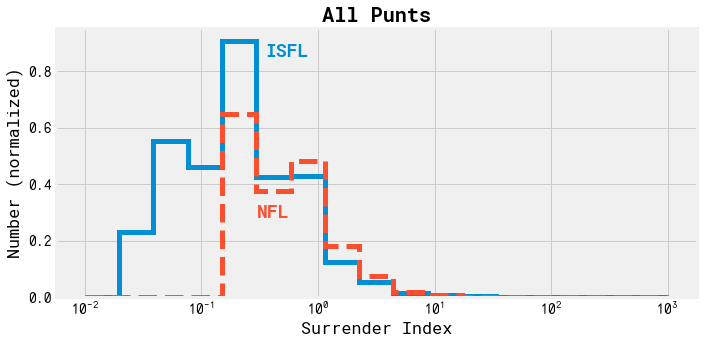

In [82]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'Roboto Mono'
plt.rcParams['font.weight'] = 'medium'
plt.xticks(fontname = 'NovaMono',weight='medium')
plt.yticks(fontname = 'NovaMono',weight='medium')
plt.title('All Punts',weight='bold')
plt.xlabel('Surrender Index')
plt.ylabel('Number (normalized)')
bins = np.logspace(-2,3,18)
plt.hist(puntDF['surrenderIndex'],bins=bins,histtype='step',color='C0',density=True,lw=5,label='NSFL')
plt.hist(NFL,bins=bins,color='C1',histtype='step',density=True,lw=5,ls='--',label='NFL')
plt.xscale('log')
plt.text(x=0.35,y=0.85,s='ISFL',c='C0',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.text(x=0.3,y=0.28,s='NFL',c='C1',weight='bold',size=18,backgroundcolor='#f0f0f0')
plt.tight_layout()
plt.savefig('images/surrenderindexes.png')
plt.show()

In [95]:
def touchback(row):
    if 'Touchback' in row['play']:
        return "Touchback"
    elif 'No return' in row['play']:
        return "No return"
    else:
        return "Returned"

def puntDist(row):
    if 'BLOCKED' in row.play:
        return 0
    elif 'Touchback' in row.play:
        return row.dist2goal - 20
    else:
        return int(row.play.split('of ')[-1].split(' yards')[0])

puntDF['result'] = puntDF.apply(lambda row : touchback(row),axis = 1)

puntDF['scoreDiff'] = puntDF.apply(lambda row : scoreDiff(row),axis = 1)

puntDF['puntDist'] = puntDF.apply(lambda row : puntDist(row),axis = 1)

puntDF['puntEndLoc'] = puntDF['dist2goal'] - puntDF['puntDist']

puntDF['surrenderRank'] = puntDF.surrenderIndex.rank(method='max',ascending=False).astype('int')

puntDF = puntDF[['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'teamPoss', 'recTeam', 'down', 'distance', 'dist2goal', 'puntDist',
       'puntEndLoc', 'surrenderIndex','surrenderRank', 'percentiles', 'NFLpercentiles', 'play',
       'result']]

In [96]:
def stringify(row):
    num = ['st','nd','rd','th']
    if row['awayTeam'] == row['teamPoss']:
        puntScore = row['awayScore']
        recScore = row['homeScore']
    else:
        puntScore = row['homeScore']
        recScore = row['awayScore']
    return "Q%s - %s - %i%s and %i\n%s %s - %s %s"%(row['Q'],row['time'],row['down'],num[int(row['down'])-1],row['distance'],row['teamPoss'],puntScore,row['recTeam'],recScore)

puntDF['situation'] = puntDF.apply(lambda row : stringify(row), axis = 1)

puntDF = puntDF[['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'teamPoss', 'recTeam', 'down', 'distance', 'dist2goal', 'puntDist',
       'puntEndLoc', 'surrenderIndex','surrenderRank', 'percentiles', 'NFLpercentiles', 'play',
       'situation','result']]

In [90]:
puntDF.sort_values('surrenderIndex',ascending=False).head(25)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,teamPoss,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,situation,result
333295,24,6138,4,2:52,PHI,12,13,AZ,PHI,AZ,4.0,2.0,32.0,12.0,20.0,1174.433,1.0,100.000000,100.000000,"Punt by Hunt (R), K. of 32 yards. Touchback.",Q4 - 2:52 - 4th and 2\nPHI 12 - AZ 13,Touchback
71520,6,1592,5,12:29,YKW,27,27,NO,NO,YKW,4.0,2.0,32.0,12.0,20.0,930.991,2.0,99.995127,100.000000,"Punt by Lombardi, J. of 32 yards. Touchback.",Q5 - 12:29 - 4th and 2\nNO 27 - YKW 27,Touchback
130167,11,2698,4,4:24,YKW,21,17,PHI,PHI,YKW,4.0,1.0,35.0,15.0,20.0,739.115,3.0,99.990254,100.000000,"Punt by (R) Fulture, K. of 35 yards. Touchback.",Q4 - 4:24 - 4th and 1\nPHI 17 - YKW 21,Touchback
5670,1,18,4,2:03,BAL,20,23,COL,BAL,COL,4.0,3.0,35.0,15.0,20.0,730.985,4.0,99.985381,100.000000,"Punt by Harris, S. of 35 yards. Touchback.",Q4 - 2:03 - 4th and 3\nBAL 20 - COL 23,Touchback
21476,3,314,4,3:16,PHI,14,17,YKW,PHI,YKW,4.0,5.0,33.0,13.0,20.0,708.052,5.0,99.980508,100.000000,"Punt by Harris, S. of 33 yards. Touchback.",Q4 - 3:16 - 4th and 5\nPHI 14 - YKW 17,Touchback
84208,7,1754,4,8:30,YKW,23,20,SJS,SJS,YKW,4.0,3.0,32.0,12.0,20.0,695.333,6.0,99.975635,100.000000,"Punt by Blewitt, I. of 32 yards. Touchback.",Q4 - 8:30 - 4th and 3\nSJS 20 - YKW 23,Touchback
83756,7,1756,4,4:04,COL,3,38,NO,COL,NO,4.0,1.0,34.0,14.0,20.0,685.835,7.0,99.970762,100.000000,"Punt by McCormick, M. of 34 yards. Touchback.",Q4 - 4:04 - 4th and 1\nCOL 3 - NO 38,Touchback
110425,9,2334,4,6:44,YKW,13,21,OCO,YKW,OCO,4.0,2.0,33.0,13.0,20.0,685.117,8.0,99.965889,100.000000,"Punt by Forfeit, N. of 33 yards. Touchback.",Q4 - 6:44 - 4th and 2\nYKW 13 - OCO 21,Touchback
262483,20,4993,4,3:20,AUS,27,34,OCO,AUS,OCO,4.0,1.0,36.0,16.0,20.0,678.819,9.0,99.961016,100.000000,"Punt by Crisco, A. of 36 yards. Touchback.",Q4 - 3:20 - 4th and 1\nAUS 27 - OCO 34,Touchback
224781,18,4609,4,3:54,BAL,23,27,AZ,BAL,AZ,4.0,1.0,36.0,16.0,20.0,644.770,10.0,99.956142,99.996018,"Punt by Brand, F. of 36 yards. Touchback.",Q4 - 3:54 - 4th and 1\nBAL 23 - AZ 27,Touchback


In [115]:
puntDF[(puntDF.S == 24) & (puntDF.teamPoss == 'AZ')]

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,teamPoss,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,situation,result
325027,24,6105,2,2:36,NO,13,3,AZ,AZ,NO,4.0,1.0,32.0,12.0,20.0,207.162,91,99.563861,99.972126,"Punt by Jay-Jaymison, J. of 32 yards. Touchback.",Q2 - 2:36 - 4th and 1\nAZ 3 - NO 13,Touchback
330613,24,6183,4,9:14,HON,28,13,AZ,AZ,HON,4.0,1.0,42.0,22.0,20.0,98.180,262,98.728132,99.824792,"Punt by Jay-Jaymison, J. of 42 yards. Touchback.",Q4 - 9:14 - 4th and 1\nAZ 13 - HON 28,Touchback
326858,24,6100,4,9:45,AZ,13,21,SJS,AZ,SJS,4.0,2.0,43.0,23.0,20.0,83.083,317,98.460114,99.796918,"Punt by Jay-Jaymison, J. of 43 yards. Touchback.",Q4 - 9:45 - 4th and 2\nAZ 13 - SJS 21,Touchback
326386,24,6100,1,8:36,AZ,0,0,SJS,AZ,SJS,4.0,2.0,34.0,14.0,20.0,76.727,370,98.216461,99.761080,"Punt by Jay-Jaymison, J. of 34 yards. Touchback.",Q1 - 8:36 - 4th and 2\nAZ 0 - SJS 0,Touchback
328190,24,6173,4,4:47,AZ,12,30,NO,AZ,NO,4.0,4.0,43.0,23.0,20.0,74.670,374,98.182350,99.749134,"Punt by Jay-Jaymison, J. of 43 yards. Touchback.",Q4 - 4:47 - 4th and 4\nAZ 12 - NO 30,Touchback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317337,24,6119,1,13:02,AZ,0,0,HON,AZ,HON,4.0,20.0,53.0,33.0,20.0,0.116,19707,4.095804,0.000000,"Punt by Jay-Jaymison, J. of 52 yards. Touchback.",Q1 - 13:02 - 4th and 20\nAZ 0 - HON 0,Touchback
317300,24,6119,1,9:22,AZ,0,0,HON,AZ,HON,4.0,11.0,53.0,41.0,12.0,0.116,19707,4.095804,0.000000,"Punt by Jay-Jaymison, J. of 41 yards.",Q1 - 9:22 - 4th and 11\nAZ 0 - HON 0,Returned
336109,24,6152,2,8:05,AZ,3,17,YKW,AZ,YKW,4.0,26.0,58.0,38.0,20.0,0.108,19759,3.839969,0.000000,"Punt by Jay-Jaymison, J. of 58 yards. Touchback.",Q2 - 8:05 - 4th and 26\nAZ 3 - YKW 17,Touchback
331964,24,6177,4,3:58,AUS,9,20,AZ,AZ,AUS,4.0,8.0,55.0,35.0,20.0,0.096,19896,3.147995,0.000000,"Punt by Jay-Jaymison, J. of 55 yards. Touchback.",Q4 - 3:58 - 4th and 8\nAZ 20 - AUS 9,Touchback


In [113]:
a = 5
try:
    if a & b:
        print("yay")
except NameError:
    if a:
        print("a")

a


In [117]:
from tabulate import tabulate
print(tabulate(puntDF[puntDF.gameID == 6380][['situation', 'play','surrenderIndex','surrenderRank']].head(10),
               headers='keys',tablefmt='simple',showindex=False))

situation                play                                            surrenderIndex    surrenderRank
-----------------------  --------------------------------------------  ----------------  ---------------
Q4 - 13:56 - 4th and 17  Punt by Banana, S. of 40 yards. Touchback.              24.357             1166
COL 6 - CHI 7
Q3 - 9:07 - 4th and 1    Punt by Banana, S. of 33 yards. No return.              22.46              1249
COL 6 - CHI 7
Q3 - 11:10 - 4th and 11  Punt by Sidekick, S. of 30 yards. Touchback.            19.888             1390
CHI 7 - COL 6
Q2 - 4:10 - 4th and 10   Punt by Sidekick, S. of 35 yards. Touchback.             7.992             2757
CHI 7 - COL 3
Q2 - 6:57 - 4th and 1    Punt by Banana, S. of 51 yards.                          4                 4269
COL 3 - CHI 7
Q3 - 4:58 - 4th and 4    Punt by Banana, S. of 60 yards. Touchback.               2.924             5287
COL 6 - CHI 7
Q1 - 12:45 - 4th and 1   Punt by Sidekick, S. of 53 yards.                  

In [87]:
puntDF[puntDF.teamPoss == "AZ"].sort_values('dist2goal')

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,teamPoss,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,situation,result
74505,7,1760,3,12:25,COL,0,21,AZ,AZ,COL,4.0,4.0,30.0,10.0,20.0,59.663,469.0,97.726719,99.565962,"Punt by Jackson, D. of 30 yards. Touchback.",Q3 - 12:25 - 4th and 4\nAZ 21 - COL 0,Touchback
274875,21,5180,3,0:34,AZ,17,21,PHI,AZ,PHI,4.0,16.0,30.0,10.0,20.0,131.215,176.0,99.147215,99.904432,"Punt by Jay-Jaymison (R), J. of 30 yards. Touc...",Q3 - 0:34 - 4th and 16\nAZ 17 - PHI 21,Touchback
144114,12,2885,1,11:18,SJS,0,0,AZ,AZ,SJS,4.0,9.0,30.0,10.0,20.0,79.550,349.0,98.321232,99.780990,"Punt by Jackson, D. of 30 yards. Touchback.",Q1 - 11:18 - 4th and 9\nAZ 0 - SJS 0,Touchback
290682,22,5368,2,13:15,AZ,0,14,SJS,AZ,SJS,4.0,10.0,31.0,11.0,20.0,49.719,598.0,97.132206,99.350934,"Punt by Jay-Jaymison, J. of 31 yards. Touchback.",Q2 - 13:15 - 4th and 10\nAZ 0 - SJS 14,Touchback
176654,15,3389,4,10:50,YKW,7,27,AZ,AZ,YKW,4.0,7.0,31.0,11.0,20.0,33.146,891.0,95.709273,98.654084,"Punt by Jackson, D. of 31 yards. Touchback.",Q4 - 10:50 - 4th and 7\nAZ 27 - YKW 7,Touchback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229299,18,4579,2,2:23,SJS,3,21,AZ,AZ,SJS,4.0,21.0,99.0,32.0,67.0,0.200,18900.0,12.245992,4.254768,"Punt by Clutch (R), C. of 32 yards. No return.",Q2 - 2:23 - 4th and 21\nAZ 21 - SJS 3,No return
165186,14,3239,1,11:13,AZ,0,0,SJS,AZ,SJS,4.0,19.0,99.0,40.0,59.0,0.400,16313.0,24.850154,14.231673,"Punt by Jackson, D. of 40 yards. No return.",Q1 - 11:13 - 4th and 19\nAZ 0 - SJS 0,No return
59058,5,1423,3,7:38,OCO,0,30,AZ,AZ,OCO,4.0,15.0,99.0,63.0,36.0,0.200,18900.0,12.245992,4.254768,"Punt by Jackson, D. of 63 yards.",Q3 - 7:38 - 4th and 15\nAZ 30 - OCO 0,Returned
132351,11,2683,1,7:24,PHI,7,0,AZ,AZ,PHI,4.0,12.0,99.0,36.0,63.0,0.800,12114.0,45.709273,35.567236,"Punt by Jackson, D. of 36 yards.",Q1 - 7:24 - 4th and 12\nAZ 0 - PHI 7,Returned


In [31]:
puntArr = []
for i in range(30,100):
    i4df = puntDF[puntDF['dist2goal'] == i]
    puntArr.append(i4df['result'].value_counts(normalize=True))

In [32]:
puntArr[3]['Touchback']

0.984375

In [33]:
tbList = []
nrList = []
rList = []
for f in puntArr:
    try:
        tbList.append(f['Touchback'])
    except KeyError:
        tbList.append(0.)
    try:
        nrList.append(f['No return'])
    except KeyError:
        nrList.append(0.)
    try:
        rList.append(f['Returned'])
    except KeyError:
        rList.append(0.)

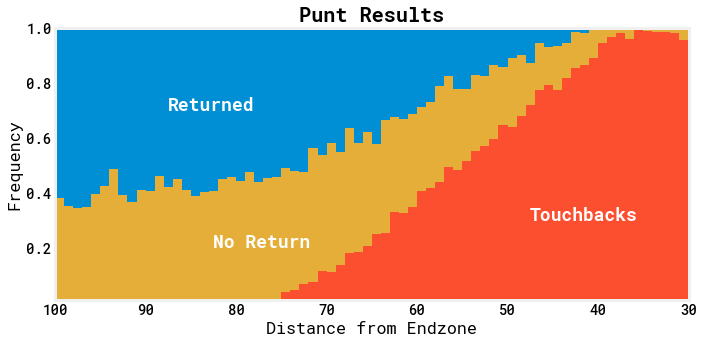

In [34]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,rList,bottom=[tbList[i]+nrList[i] for i in range(len(yardRange))],width=1,label='Returned',color='C0',align='edge')
plt.bar(yardRange,nrList,bottom=tbList,width=1,label='No Return',color='C2',align='edge')
plt.bar(yardRange,tbList,width=1,label='Touchback',color='C1',align='edge')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 47.5, y = 0.3, s = 'Touchbacks', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 82.5, y = 0.2, s = 'No Return', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 87.5, y = 0.7, s = 'Returned', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.xlim(100,30)
plt.ylim(0.01,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results.png')
plt.show()

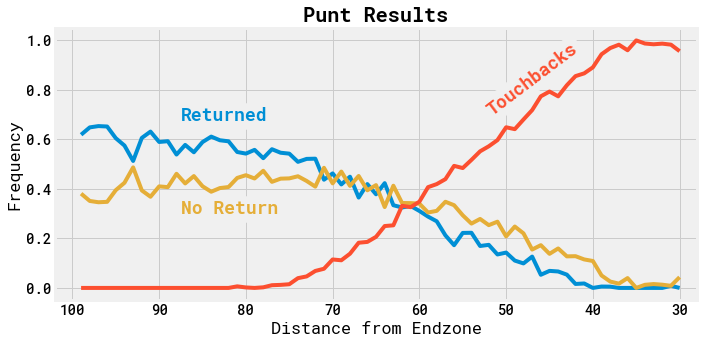

In [35]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.plot(yardRange,rList,label='Returned',color='C0')
plt.plot(yardRange,nrList,label='No Return',color='C2')
plt.plot(yardRange,tbList,label='Touchback',color='C1')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 52.5, y = 0.7, s = 'Touchbacks', color = 'C1', weight = 'bold', size = 18, rotation = 37, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.3, s = 'No Return', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.675, s = 'Returned', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.xlim(102,28)
# plt.ylim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results_line.png')
plt.show()

In [36]:
puntDF.columns

Index(['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'teamPoss', 'recTeam', 'down', 'distance', 'side',
       'dist2goal', 'puntDist', 'puntEndLoc', 'surrenderIndex', 'percentiles',
       'NFLpercentiles', 'play', 'result'],
      dtype='object')

In [37]:
puntDF['surrenderRank'] = puntDF.surrenderIndex.rank(method='max',ascending=False)
puntDF = puntDF[['S', 'gameID', 'Q', 'time', 'awayTeam', 'awayScore', 'homeScore',
       'homeTeam', 'teamPoss', 'recTeam', 'down', 'distance', 'dist2goal', 'puntDist',
       'puntEndLoc', 'surrenderIndex','surrenderRank', 'percentiles', 'NFLpercentiles', 'play',
       'result']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0f8d6bf90>]],
      dtype=object)

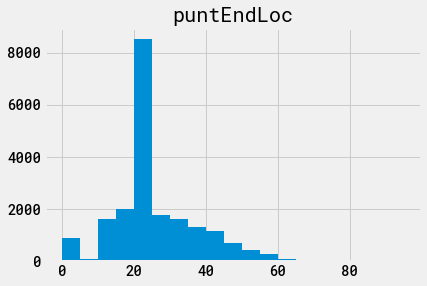

In [38]:
puntDF.hist('puntEndLoc',bins=np.arange(0,100,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0f8eccf10>]],
      dtype=object)

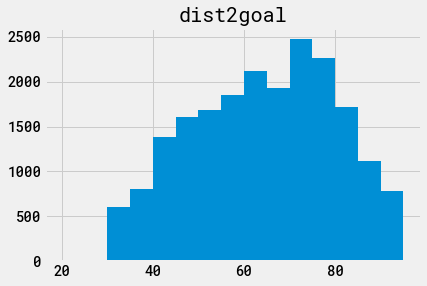

In [39]:
puntDF.hist('dist2goal',bins=np.arange(20,100,5))

In [40]:
min(puntDF.dist2goal)

30.0

In [41]:
puntEndArr = []
for i in range(0,100):
    i4df = puntDF[puntDF['dist2goal'] == i]
    puntEndArr.append(i4df['puntEndLoc'].value_counts(normalize=True))

In [42]:
in20 = 0
tb = 0
out20 = 0
for key,val in puntEndArr[30].items():
    if key < 20:
        in20 += val
    elif key == 20:
        tb += val
    else:
        out20 += val
print(in20, tb, out20)

0.021739130434782608 0.9565217391304348 0.021739130434782608


In [43]:
in20List = []
tb20List = []
out20List = []
for f in puntEndArr[30:]:
    in20 = 0
    tb = 0
    out20 = 0
    for key,val in f.items():
        if key < 20:
            in20 += val
        elif key == 20:
            tb += val
        else:
            out20 += val
    in20List.append(in20)
    tb20List.append(tb)
    out20List.append(out20)

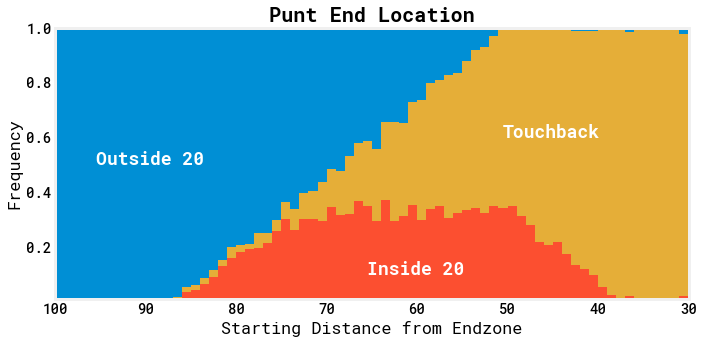

In [44]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt End Location',weight='bold')
plt.xlabel('Starting Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,out20List,bottom=[tb20List[i]+in20List[i] for i in range(len(yardRange))],width=1,label='Outside 20',color='C0',align='edge')
plt.bar(yardRange,tb20List,bottom=in20List,width=1,label='Touchback',color='C2',align='edge')
plt.bar(yardRange,in20List,width=1,label='Inside 20',color='C1',align='edge')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 65.5, y = 0.1, s = 'Inside 20', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 50.5, y = 0.6, s = 'Touchback', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 95.5, y = 0.5, s = 'Outside 20', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.xlim(100,30)
plt.ylim(0.01,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results.png')
plt.show()

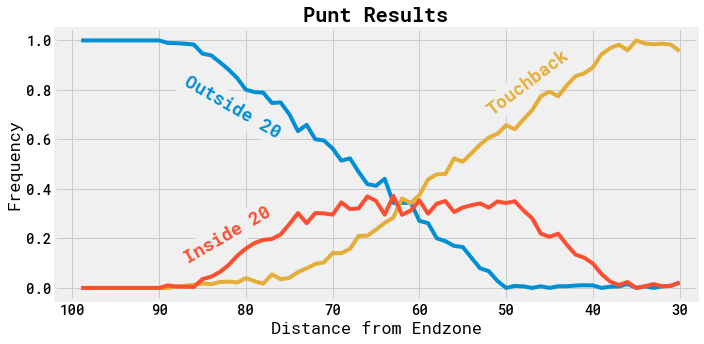

In [45]:
yardRange = range(30,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Punt Results',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.plot(yardRange,out20List,label='Outside 20',color='C0')
plt.plot(yardRange,tb20List,label='Touchback',color='C2')
plt.plot(yardRange,in20List,label='Inside 20',color='C1')
# for i in [30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.text(x = 52.5, y = 0.7, s = 'Touchback', color = 'C2', weight = 'bold', size = 18, rotation = 37, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.1, s = 'Inside 20', color = 'C1', weight = 'bold', size = 18, rotation = 30, backgroundcolor = '#f0f0f0')
plt.text(x = 87.5, y = 0.605, s = 'Outside 20', color = 'C0', weight = 'bold', size = 18, rotation = -30,backgroundcolor = '#f0f0f0')
plt.xlim(102,28)
# plt.ylim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('images/punt_results_line.png')
plt.show()

In [46]:
puntDF[puntDF.puntEndLoc < 20].sort_values('dist2goal',ascending = False).head(10)

,S,gameID,Q,time,awayTeam,awayScore,homeScore,homeTeam,teamPoss,recTeam,down,distance,dist2goal,puntDist,puntEndLoc,surrenderIndex,surrenderRank,percentiles,NFLpercentiles,play,result
233931,24,6094,2,6:24,NO,10,0,SJS,SJS,NO,4.0,10.0,89.0,70.0,19.0,0.600000,13211.0,36.755031,26.466372,"Punt by McDairmid, M. of 70 yards. No return.",No return
151705,20,5002,3,10:25,AUS,3,13,AZ,AUS,AZ,4.0,9.0,89.0,71.0,18.0,1.224956,8478.0,58.693533,51.495242,"Punt by Crisco, A. of 71 yards. No return.",No return
258338,3,306,1,5:12,ARI,3,0,YKW,ARI,YKW,4.0,10.0,88.0,69.0,19.0,0.200000,18900.0,12.245992,4.254768,"Punt by Ronaldo, C. of 69 yards. No return.",No return
226898,24,6121,3,4:46,COL,9,7,SJS,SJS,COL,4.0,16.0,87.0,76.0,11.0,0.985180,9745.0,52.516934,43.527257,"Punt by McDairmid, M. of 76 yards.",Returned
63948,15,3360,3,2:29,PHI,16,13,SJS,PHI,SJS,4.0,16.0,86.0,67.0,19.0,0.200000,18900.0,12.245992,4.254768,"Punt by Fulture, K. of 67 yards.",Returned
194544,23,5603,1,5:38,SAR,0,2,YKW,YKW,SAR,4.0,6.0,85.0,66.0,19.0,0.600000,14084.0,33.497393,22.910445,"Punt by Smalls, D. of 66 yards. No return.",No return
147351,20,4981,4,10:44,BAL,3,12,COL,BAL,COL,4.0,20.0,85.0,66.0,19.0,1.526883,8067.0,60.693923,54.889898,"Punt by Brand, F. of 66 yards. No return.",No return
114804,18,4599,1,3:24,AUS,7,7,CHI,AUS,CHI,4.0,29.0,85.0,68.0,17.0,0.400000,16313.0,24.825788,14.231673,"Punt by Crisco, A. of 68 yards.",Returned
290314,6,1579,1,6:45,BAL,0,0,COL,BAL,COL,4.0,27.0,85.0,70.0,15.0,0.400000,16313.0,24.825788,14.231673,"Punt by Turkleton, T. of 70 yards.",Returned
154997,20,5018,1,3:01,PHI,3,7,OCO,PHI,OCO,4.0,17.0,85.0,66.0,19.0,0.800000,12114.0,45.650797,35.567236,"Punt by Powers (R), V. of 66 yards. No return.",No return


In [47]:
puntDF.to_csv('allpunts.csv')

## Fourth Downs

In [48]:
fourthDF = allData[allData['down'] == 4.0]

In [49]:
def playType(play):
#     print(play)
    if 'Punt' in play:
        ptype = 'Punt'
    elif 'FG' in play:
        ptype = 'FG'
    elif 'Timeout' in play:
        ptype = 'Timeout'
    else:
        ptype = 'Try'
    return ptype

In [50]:
fourthDF = fourthDF.rename(columns = {'teamPoss':'recTeam'})

In [51]:
fourthDF['playType'] = fourthDF.apply(lambda row : playType(row['play']),axis=1)

In [52]:
def fixAZBug2(row):
    try:
        if row['recTeam'] == 'AZ' and row['playType'] == 'Punt':
            row['dist2goal'] = 100 - row['dist2goal']
            if row['homeTeam'] == 'AZ':
                row['side'] = row['awayTeam']
            else:
                row['side'] = row['homeTeam']
        return row
    except KeyError:
        return row

In [53]:
fourthDF = fourthDF.apply(lambda row : fixAZBug2(row),axis=1)

In [54]:
fourthDF['scoreDiff'] = fourthDF.apply(lambda row : scoreDiff(row),axis=1)

In [55]:
fourthDF = fourthDF[~fourthDF['playType'].str.contains('Timeout')]

In [56]:
fourthDF = fourthDF[~fourthDF['play'].str.contains('Penalty')]

In [57]:
fourthTryDF = fourthDF[fourthDF['playType'] == 'Try']

In [58]:
fourthDF = fourthDF[~fourthDF['play'].str.contains('Turnover')]

In [59]:
fourthDF['playType'].value_counts(normalize=True)

Punt    0.716916
FG      0.191972
Try     0.091112
Name: playType, dtype: float64

In [60]:
fourthArr = []
for i in range(1,100):
    i4df = fourthDF[fourthDF['dist2goal'] == i]
    fourthArr.append(i4df['playType'].value_counts(normalize=True))

In [61]:
fourthArr[0]['FG']

0.9096385542168675

In [62]:
FGlist = []
PuntList = []
TryList = []
TOList = []
for f in fourthArr:
    try:
        FGlist.append(f['FG'])
    except KeyError:
        FGlist.append(0.)
    try:
        PuntList.append(f['Punt'])
    except KeyError:
        PuntList.append(0.)
    try:
        TryList.append(f['Try'])
    except KeyError:
        TryList.append(0.)
    try:
        TOList.append(f['Timeout'])
    except KeyError:
        TOList.append(0.)

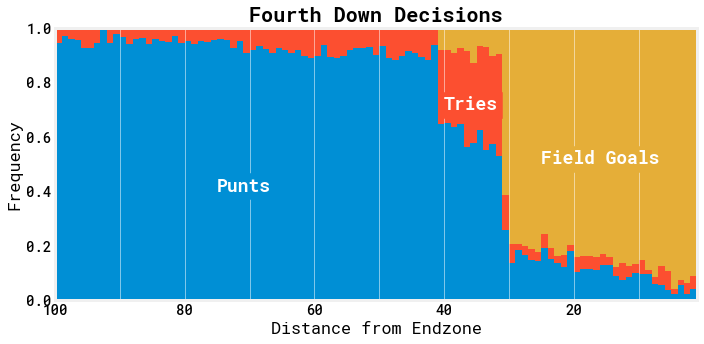

In [63]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
plt.bar(yardRange,FGlist,bottom=[TryList[i]+PuntList[i] for i in range(99)],width=1,label='Field Goals',color='C2',align='edge')
plt.bar(yardRange,TryList,bottom=PuntList,width=1,label='Tries',color='C1',align='edge')
plt.bar(yardRange,PuntList,width=1,label='Punts',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(100,1)
plt.ylim(0,1)
plt.text(x = 40, y = 0.7, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 25, y = 0.5, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 75, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
# plt.legend(loc=5)
plt.tight_layout()
plt.savefig('images/4thdownbar.png')
plt.show()

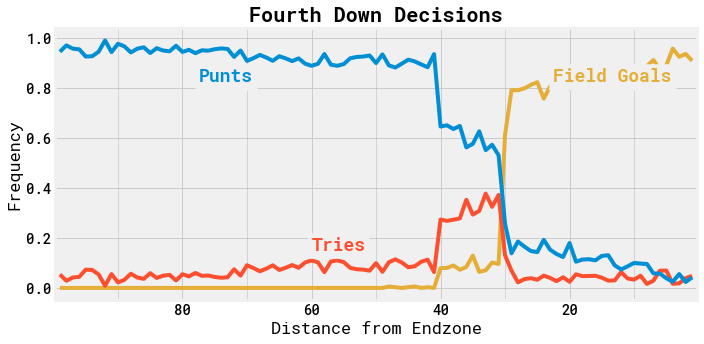

In [64]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
for i in [10,30,50,70,90]:
    plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
plt.xlim(99.75,0.25)
# plt.ylim(0,1)
# plt.legend(loc=5)
plt.text(x = 60, y = 0.15, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 22.5, y = 0.825, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 77.5, y = 0.825, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdownline.png')
plt.show()

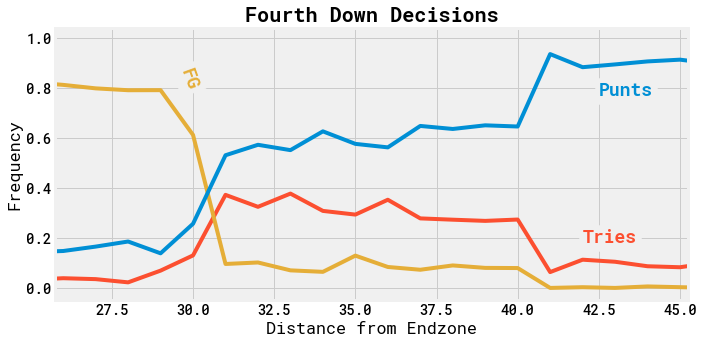

In [65]:
yardRange = range(1,100)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions',weight='bold')
plt.xlabel('Distance from Endzone')
plt.ylabel('Frequency')
# plt.plot(yardRange,TOList,label='Timeouts',c='C3')
plt.plot(yardRange,TryList,label='Tries',c='C1')
plt.plot(yardRange,FGlist,label='Field Goals',c='C2')
plt.plot(yardRange,PuntList,label='Punts',c='C0')
# for i in [10,30,50,70,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.25)
plt.xlim(25.75,45.25)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 42, y = 0.18, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 29.5, y = 0.8, s = 'FG', color = 'C2', weight = 'bold', rotation = -70, size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 42.5, y = 0.77, s = 'Punts', color = 'C0', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdown_dead.png')
plt.show()

In [66]:
deadZoneDF = fourthDF[(fourthDF['dist2goal'] <= 40) & (30 <= fourthDF['dist2goal'])]

In [67]:
len(deadZoneDF)

3293

In [68]:
deadZoneArr = []
deadZoneArrn = []
for i in range(1,51):
    i4df = deadZoneDF[deadZoneDF['distance'] == i]
    deadZoneArr.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrn.append(i4df['playType'].value_counts(normalize=False))

In [69]:
dFGlist = []
dPuntList = []
dTryList = []
dTOList = []
noneList = []

for f in deadZoneArr:
    i = 0
    try:
        dFGlist.append(f['FG'])
    except KeyError:
        dFGlist.append(0.)
        i += 1
    try:
        dPuntList.append(f['Punt'])
    except KeyError:
        dPuntList.append(0.)
        i+=1
    try:
        dTryList.append(f['Try'])
    except KeyError:
        dTryList.append(0.)

In [70]:
dFGlistn = []
dPuntListn = []
dTryListn = []
dTOListn = []
noneListn = []

for f in deadZoneArrn:
    i = 0
    try:
        dFGlistn.append(f['FG'])
    except KeyError:
        dFGlistn.append(0.)
        i += 1
    try:
        dPuntListn.append(f['Punt'])
    except KeyError:
        dPuntListn.append(0.)
        i+=1
    try:
        dTryListn.append(f['Try'])
    except KeyError:
        dTryListn.append(0.)

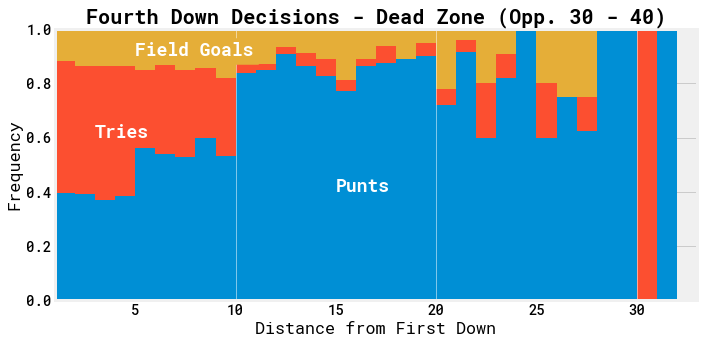

In [71]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntList,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryList,bottom=dPuntList,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlist,bottom=[dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,33)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 3, y = 0.6, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.9, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 15, y = 0.4, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/4thdown_deadDist.png')
plt.show()

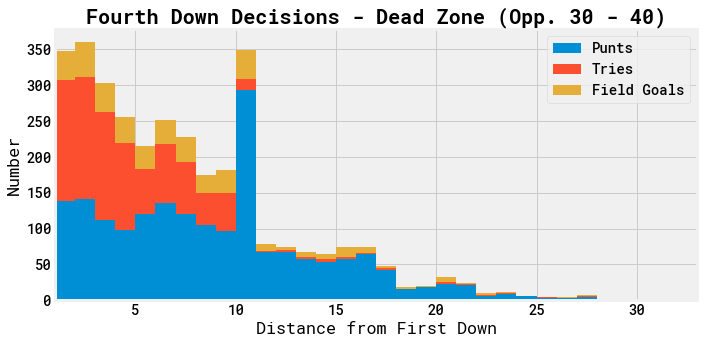

In [72]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListn,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListn,bottom=dPuntListn,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistn,bottom=[dTryListn[i]+dPuntListn[i] for i in range(50)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,33)
plt.legend()
plt.tight_layout()
plt.savefig('images/4thdown_deadDist_total.png')
plt.show()

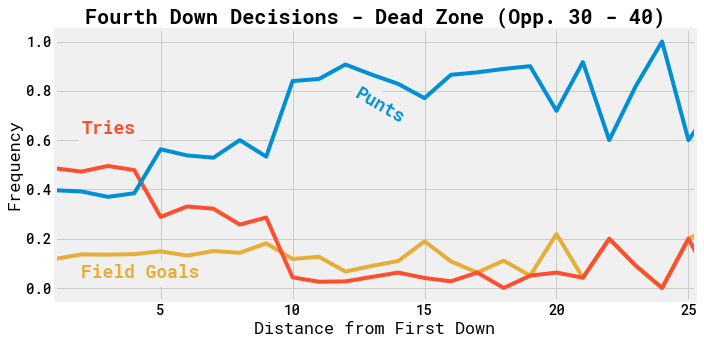

In [73]:
yardRange = range(1,51)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Distance from First Down')
plt.ylabel('Frequency')
plt.plot(yardRange,dFGlist,label='Field Goals',c='C2')
plt.plot(yardRange,dTryList,label='Tries',c='C1')
plt.plot(yardRange,dPuntList,label='Punts',c='C0')
# plt.plot(yardRange,dTOList,label='Timeouts')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(1,25.25)
# plt.ylim(0,1.01)
# plt.legend(loc=0)
plt.text(x = 2, y = 0.625, s = 'Tries', color = 'C1', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 2, y = 0.04, s = 'Field Goals', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 12.25, y = 0.67, s = 'Punts', color = 'C0', weight = 'bold', rotation = -30, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/4thdown_deadDist_line.png')
plt.show()

In [74]:
deadZoneDF4q = deadZoneDF[deadZoneDF['Q'] >= 4]
len(deadZoneDF4q)

941

In [75]:
deadZoneArrPD = []
deadZoneArrPDn = []
for i in range(0,16):
    i4df = deadZoneDF4q[deadZoneDF4q['scoreDiff'] == i]
    deadZoneArrPD.append(i4df['playType'].value_counts(normalize=True))
    deadZoneArrPDn.append(i4df['playType'].value_counts(normalize=False))

In [76]:
dFGlistpd = []
dPuntListpd = []
dTryListpd = []
dTOListpd = []
noneListpd = []

for f in deadZoneArrPD:
    i = 0
    try:
        dFGlistpd.append(f['FG'])
    except KeyError:
        dFGlistpd.append(0.)
        i += 1
    try:
        dPuntListpd.append(f['Punt'])
    except KeyError:
        dPuntListpd.append(0.)
        i+=1
    try:
        dTryListpd.append(f['Try'])
    except KeyError:
        dTryListpd.append(0.)

In [77]:
dFGlistnpd = []
dPuntListnpd = []
dTryListnpd = []
dTOListnpd = []
noneListnpd = []

for f in deadZoneArrPDn:
    i = 0
    try:
        dFGlistnpd.append(f['FG'])
    except KeyError:
        dFGlistnpd.append(0.)
        i += 1
    try:
        dPuntListnpd.append(f['Punt'])
    except KeyError:
        dPuntListnpd.append(0.)
        i+=1
    try:
        dTryListnpd.append(f['Try'])
    except KeyError:
        dTryListnpd.append(0.)

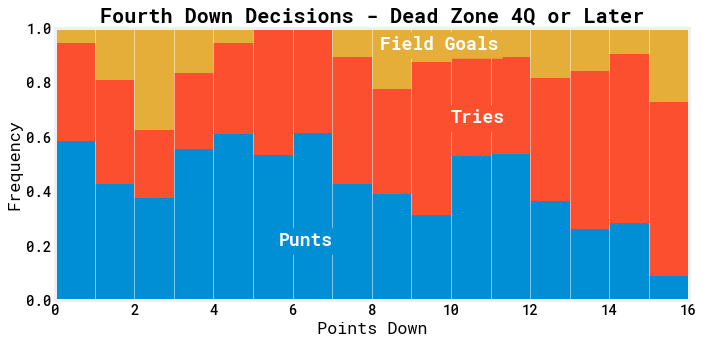

In [78]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone 4Q or Later',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Frequency')
plt.bar(yardRange,dPuntListpd,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListpd,bottom=dPuntListpd,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistpd,bottom=[dTryListpd[i]+dPuntListpd[i] for i in range(len(dFGlistpd))],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
for i in range(16):
    plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0,16)
plt.ylim(0,1)
# plt.legend()
plt.text(x = 10, y = 0.65, s = 'Tries', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 8.2, y = 0.92, s = 'Field Goals', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C2')
plt.text(x = 5.65, y = 0.2, s = 'Punts', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/4thdown_deadPD.png')
plt.show()

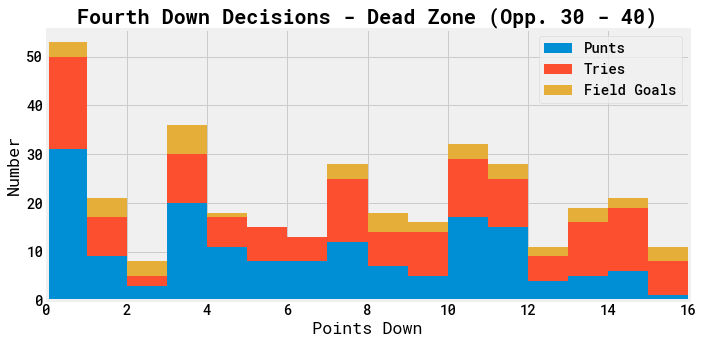

In [79]:
yardRange = range(0,16)

plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Fourth Down Decisions - Dead Zone (Opp. 30 - 40)',weight='bold')
plt.xlabel('Points Down')
plt.ylabel('Number')
plt.bar(yardRange,dPuntListnpd,width=1,label='Punts',align='edge')
plt.bar(yardRange,dTryListnpd,bottom=dPuntListnpd,width=1,label='Tries',align='edge')
plt.bar(yardRange,dFGlistnpd,bottom=[dTryListnpd[i]+dPuntListnpd[i] for i in range(16)],width=1,label='Field Goals',align='edge')
# plt.bar(yardRange,dTOList,bottom=[dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='Timeouts')
# plt.bar(yardRange,noneList,bottom=[dTOList[i] + dFGlist[i] + dTryList[i]+dPuntList[i] for i in range(50)],width=1,label='No Data',color='lightgray')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(0,16)
plt.legend()
plt.tight_layout()
plt.savefig('images/4thdown_deadPD_total.png')
plt.show()

## Field Goals

In [80]:
FGDF = allData[(allData['play'].str.contains('FG'))]

In [81]:
def fgDist(play):
    return int(play[:2])

In [82]:
FGDF['FGdist'] = FGDF.apply(lambda row : fgDist(row['play']),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
def fgRes(play):
    if 'BLOCKED' in play:
        return 'Block'
    elif 'NO good' in play:
        return 'Miss'
    else:
        return 'Good'

In [84]:
FGDF['FGresult'] = FGDF.apply(lambda row : fgRes(row['play']),axis=1)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
FGDF['FGresult'].value_counts(normalize=True)

Good     0.880513
Miss     0.117347
Block    0.002140
Name: FGresult, dtype: float64

In [86]:
fgDistArr = []
fgDistArrn = []
fgRange = np.arange(20,100,5)
for i in fgRange:
    i4df = FGDF[(i-5 < FGDF['FGdist']) & (FGDF['FGdist'] <= i)]
    fgDistArr.append(i4df['FGresult'].value_counts(normalize=True))
    fgDistArrn.append(i4df['FGresult'].value_counts(normalize=False))

In [87]:
goodList = []
missList = []
blockList = []
for f in fgDistArr:
    try:
        goodList.append(f['Good'])
    except KeyError:
        goodList.append(0.)
    try:
        missList.append(f['Miss'])
    except KeyError:
        missList.append(0.)
    try:
        blockList.append(f['Block'])
    except KeyError:
        blockList.append(0.)

In [88]:
goodListn = []
missListn = []
blockListn = []
for f in fgDistArrn:
    try:
        goodListn.append(f['Good'])
    except KeyError:
        goodListn.append(0.)
    try:
        missListn.append(f['Miss'])
    except KeyError:
        missListn.append(0.)
    try:
        blockListn.append(f['Block'])
    except KeyError:
        blockListn.append(0.)

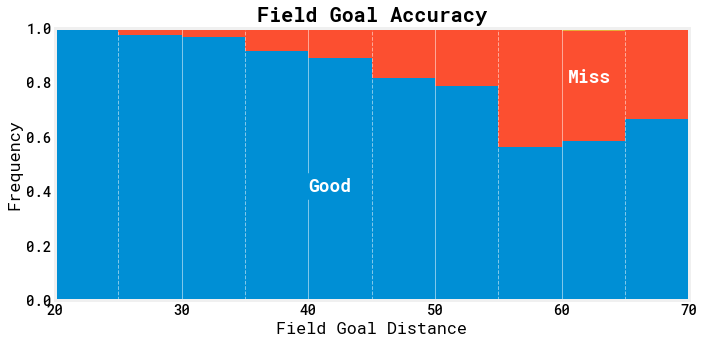

In [89]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Frequency')
plt.bar(fgRange,blockList,bottom=[goodList[i]+missList[i] for i in range(len(goodList))],width=5,label='Block',color='C2',align='edge')
plt.bar(fgRange,missList,bottom=goodList,width=5,label='Miss',color='C1',align='edge')
plt.bar(fgRange,goodList,width=5,label='Good',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(20,70)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 60.5, y = 0.8, s = 'Miss', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.4, s = 'Good', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/fgResults.png')
plt.show()

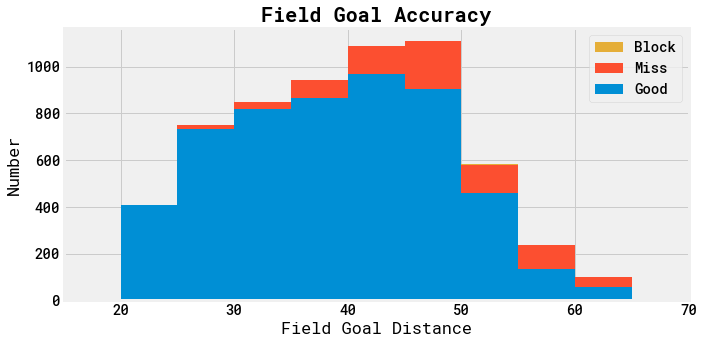

In [90]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Number')
plt.bar(fgRange,blockListn,bottom=[goodListn[i]+missListn[i] for i in range(len(goodListn))],width=5,label='Block',color='C2',align='edge')
plt.bar(fgRange,missListn,bottom=goodListn,width=5,label='Miss',color='C1',align='edge')
plt.bar(fgRange,goodListn,width=5,label='Good',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='gray',lw=1,alpha=0.1)
plt.xlim(15,70)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/fgResults_total.png')
plt.show()

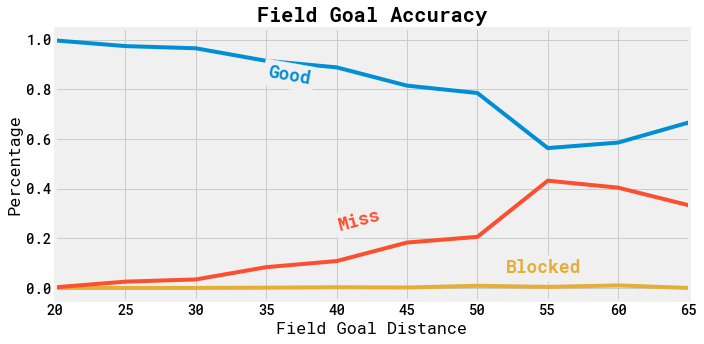

In [91]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Field Goal Accuracy',weight='bold')
plt.xlabel('Field Goal Distance')
plt.ylabel('Percentage')
plt.plot(fgRange,blockList,label='Block',c='C2')
plt.plot(fgRange,missList,label='Miss',c='C1')
plt.plot(fgRange,goodList,label='Good',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
plt.xlim(20,65)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.23, s = 'Miss', color = 'C1', weight = 'bold', size = 18, rotation = 15, backgroundcolor = '#f0f0f0')
plt.text(x = 52, y = 0.06, s = 'Blocked', color = 'C2', weight = 'bold', size = 18, backgroundcolor = '#f0f0f0')
plt.text(x = 35, y = 0.82, s = 'Good', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/fgResults_line.png')
plt.show()

In [92]:
over50 = FGDF[FGDF.FGdist >= 50][['S','gameID','homeTeam','awayTeam','Q','time','down','distance','dist2goal','teamPoss','play','awayScore','homeScore','FGdist','FGresult']].sort_values('FGdist',ascending=False)

(array([42., 36., 58., 41., 48., 53., 53., 45.,  0.,  1.,  0.,  2.,  1.,
         0.,  1.,  2.]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <a list of 16 Patch objects>)

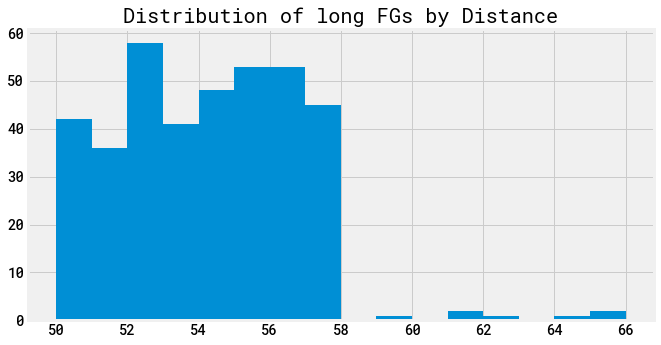

In [93]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5),facecolor='w')
plt.title('Distribution of long FGs by Distance')
plt.hist(over50['FGdist'],bins=np.arange(50,67,1))

In [94]:
FGDF[FGDF['FGresult'] == 'Block']

,Unnamed: 0,index,Unnamed: 0.1,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,teamPoss,dist2goal,awayScore,homeScore,FGdist,FGresult
50216,50216,12010,97,3,2,0:26,1826,1.0,10.0,PHI,30.0,"47 yard FG by Corbett, K. is BLOCKED by Felix,...",3112,13,COL,PHI,COL,30.0,7,31,47,Block
52607,52607,1899,47,8,1,1:25,2785,4.0,5.0,PHI,25.0,"42 yard FG by Meoff, B. is BLOCKED by (R) Fort...",3214,14,PHI,NO,NO,25.0,7,14,42,Block
89496,89496,13909,104,9,2,0:16,1816,4.0,4.0,BAL,29.0,"46 yard FG by Fulture, K. is BLOCKED by Hobbs,...",3934,16,CHI,BAL,CHI,29.0,7,9,46,Block
115859,115859,9830,84,1,2,0:11,1811,1.0,10.0,SJS,23.0,"40 yard FG by Brand, F. is BLOCKED by Riposte,...",4604,18,SJS,BAL,BAL,23.0,10,14,40,Block
129157,129157,8244,18,8,1,9:18,3258,4.0,4.0,OCO,25.0,"42 yard FG by Prohaska (R), H. is BLOCKED by A...",4845,19,NO,OCO,NO,25.0,7,0,42,Block
153824,153824,8742,170,1,4,5:36,336,4.0,2.0,SJS,29.0,"46 yard FG by Brand, F. is BLOCKED by Beck, C..",5012,20,BAL,SJS,BAL,29.0,27,20,46,Block
157665,157665,12583,109,9,2,0:05,1805,1.0,10.0,AUS,33.0,"50 yard FG by Fulture, K. is BLOCKED by Sexjok...",5030,20,CHI,AUS,CHI,33.0,17,6,50,Block
166127,166127,5913,129,3,3,10:27,1527,4.0,9.0,CHI,16.0,"33 yard FG by Banana (R), S. is BLOCKED by Rid...",5181,21,CHI,COL,COL,16.0,21,17,33,Block
213755,213755,20781,98,3,2,0:15,1815,3.0,10.0,YKW,38.0,"55 yard FG by Banana, S. is BLOCKED by Alexand...",5696,23,YKW,COL,COL,38.0,10,7,55,Block
242252,242252,2794,147,7,3,0:22,922,4.0,5.0,BAL,22.0,"39 yard FG by Harris, S. is BLOCKED by Nasher,...",84,2,PHI,BAL,PHI,22.0,27,14,39,Block


## Drive Endings

In [95]:
todDF = allData[(allData['play'].str.contains('Turnover'))]

In [96]:
tdDF = allData[(allData['play'].str.contains('TOUCHDOWN'))]

In [97]:
safetyDF = allData[(allData['play'].str.contains('SAFETY'))]

In [98]:
intDF = allData[(allData['play'].str.contains('INTERCEPTION'))]

In [99]:
fumbleDF = allData[(allData['play'].str.contains('FUMBLE'))]

In [100]:
pies = [len(puntDF),len(FGDF),len(todDF),len(tdDF),len(intDF),len(fumbleDF),len(safetyDF)]

In [101]:
labels = ['Punts (%.2f%%)'%(len(puntDF)/sum(pies)*100),
          'FG Att (%.2f%%)'%(len(FGDF)/sum(pies)*100),
          'Turnover (%.2f%%)'%(len(todDF)/sum(pies)*100),
          'Touchdown (%.2f%%)'%(len(tdDF)/sum(pies)*100),
          'Interception (%.2f%%)'%(len(intDF)/sum(pies)*100),
          'Fumble (%.2f%%)'%(len(fumbleDF)/sum(pies)*100),
          'Safety (%.2f%%)'%(len(safetyDF)/sum(pies)*100)]

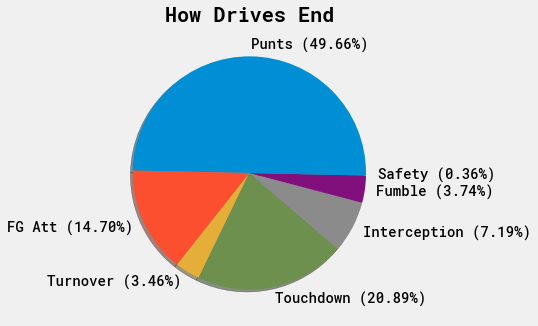

In [102]:
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.title('How Drives End',weight='bold')
plt.pie(pies,labels=labels,shadow=True)
plt.savefig('images/piechart.png')
plt.show()

## Tries

In [103]:
triesDF = fourthTryDF[(fourthTryDF['playType'] == 'Try')]

In [104]:
pd.set_option('display.max_columns', None)  

In [105]:
turnoverList = triesDF.index[triesDF['play'].str.contains('Turnover')].tolist()

In [106]:
intlist = triesDF.index[triesDF['play'].str.contains('INTERCEPTION')].tolist()

In [107]:
fumblelist = triesDF.index[triesDF['play'].str.contains('FUMBLE')].tolist()

In [108]:
turnoverList = [t-1 for t in turnoverList]
turnoverList = turnoverList + intlist + fumblelist

In [109]:
triesDF['tryResult'] = 'Good'

In [110]:
triesDF['tryResult'].loc[turnoverList] = 'Fail'

/home/mike/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [111]:
triesDF = triesDF[~triesDF['play'].str.contains('Turnover')]

In [112]:
triesDF['tryResult'].value_counts(normalize=True)

Fail    0.566334
Good    0.433666
Name: tryResult, dtype: float64

In [113]:
triesDistArr = []
triesDistArrn = []
triesRange = np.arange(1,40,1)
for i in triesRange:
    i4df = triesDF[triesDF['distance'] == i]
    triesDistArr.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn.append(i4df['tryResult'].value_counts(normalize=False))

In [114]:
triesgoodList = []
triesmissList = []
for f in triesDistArr:
    try:
        triesgoodList.append(f['Good'])
    except KeyError:
        triesgoodList.append(0.)
    try:
        triesmissList.append(f['Fail'])
    except KeyError:
        triesmissList.append(0.)

In [115]:
triesgoodListn = []
triesmissListn = []
for f in triesDistArrn:
    try:
        triesgoodListn.append(f['Good'])
    except KeyError:
        triesgoodListn.append(0.)
    try:
        triesmissListn.append(f['Fail'])
    except KeyError:
        triesmissListn.append(0.)

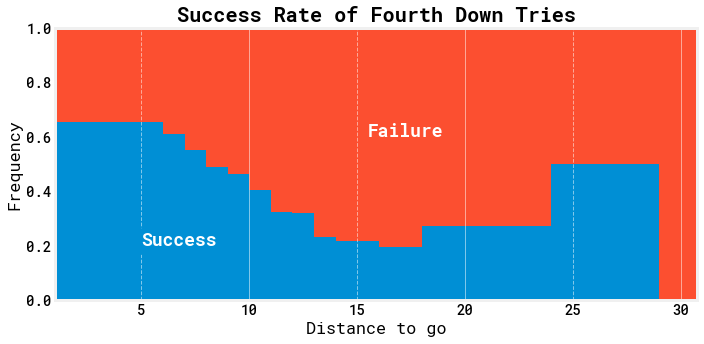

In [116]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.bar(triesRange,triesmissList,bottom=triesgoodList,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange,triesgoodList,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,30.75)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 15.5, y = 0.6, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 5, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/tryResults.png')
plt.show()

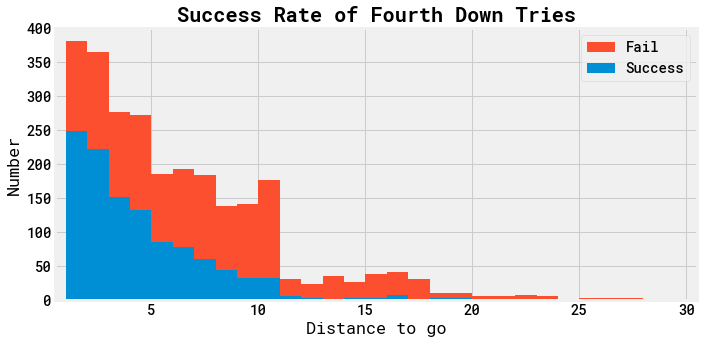

In [117]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Number')
plt.bar(triesRange,triesmissListn,bottom=triesgoodListn,width=1,label='Fail',color='C1',align='edge')
plt.bar(triesRange,triesgoodListn,width=1,label='Success',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,30.5)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/tryResults_total.png')
plt.show()

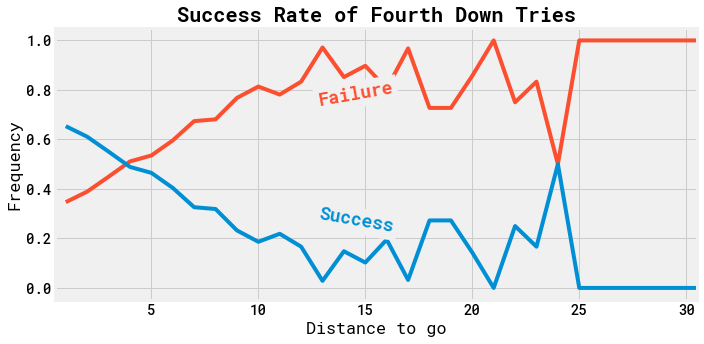

In [118]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to go')
plt.ylabel('Frequency')
plt.plot(triesRange,triesmissList,label='Fail',color='C1')
plt.plot(triesRange,triesgoodList,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 12.75, y = 0.735, s = 'Failure', color = 'C1', weight = 'bold', size = 18, rotation = 10, backgroundcolor = '#f0f0f0')
plt.text(x = 12.75, y = 0.225, s = 'Success', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/tryResults_line.png')
plt.show()

In [119]:
triesDistArr2 = []
triesDistArrn2 = []
triesRange2 = np.arange(0,100,5)
for i in triesRange2:
    i4df = triesDF[triesDF['dist2goal'] == i]
    triesDistArr2.append(i4df['tryResult'].value_counts(normalize=True))
    triesDistArrn2.append(i4df['tryResult'].value_counts(normalize=False))

In [120]:
triesgoodList2 = []
triesmissList2 = []
for f in triesDistArr2:
    try:
        triesgoodList2.append(f['Good'])
    except KeyError:
        triesgoodList2.append(0.)
    try:
        triesmissList2.append(f['Fail'])
    except KeyError:
        triesmissList2.append(0.)

In [121]:
triesgoodListn2 = []
triesmissListn2 = []
for f in triesDistArrn2:
    try:
        triesgoodListn2.append(f['Good'])
    except KeyError:
        triesgoodListn2.append(0.)
    try:
        triesmissListn2.append(f['Fail'])
    except KeyError:
        triesmissListn2.append(0.)

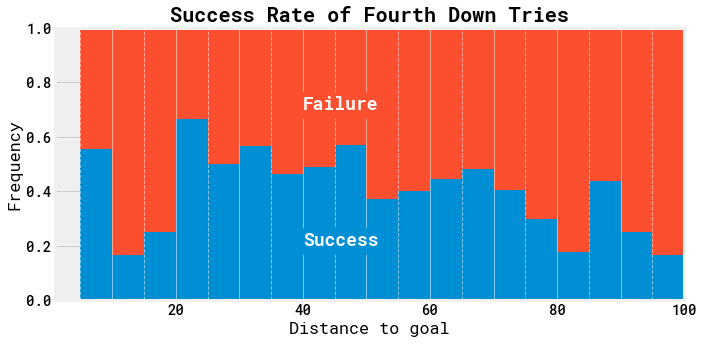

In [122]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.bar(triesRange2,triesmissList2,bottom=triesgoodList2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodList2,width=5,label='Success',color='C0',align='edge')
for i in [10,20,30,40,50,60,70,80,90]:
    plt.axvline(i,c='w',lw=1,alpha=0.5)
for i in [5,15,25,35,45,55,65,75,85,95]:
    plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(1,100)
plt.ylim(0,1)
# plt.legend(loc=1)
plt.text(x = 40, y = 0.7, s = 'Failure', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C1')
plt.text(x = 40, y = 0.2, s = 'Success', color = 'w', weight = 'bold', size = 18, backgroundcolor = 'C0')
plt.tight_layout()
plt.savefig('images/tryResults_field.png')
plt.show()

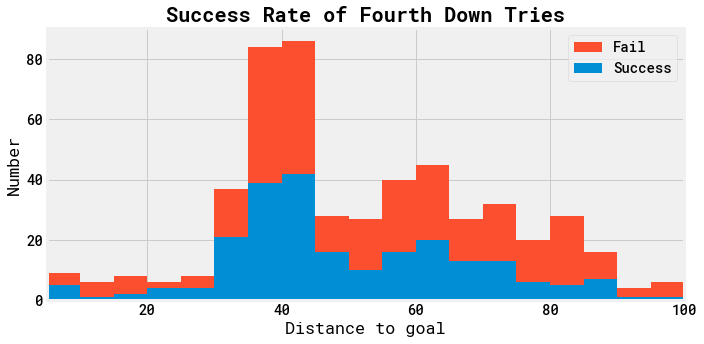

In [123]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Number')
plt.bar(triesRange2,triesmissListn2,bottom=triesgoodListn2,width=5,label='Fail',color='C1',align='edge')
plt.bar(triesRange2,triesgoodListn2,width=5,label='Success',color='C0',align='edge')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
plt.xlim(5,100)
# plt.ylim(0,1)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('images/tryResults_field_total.png')
plt.show()

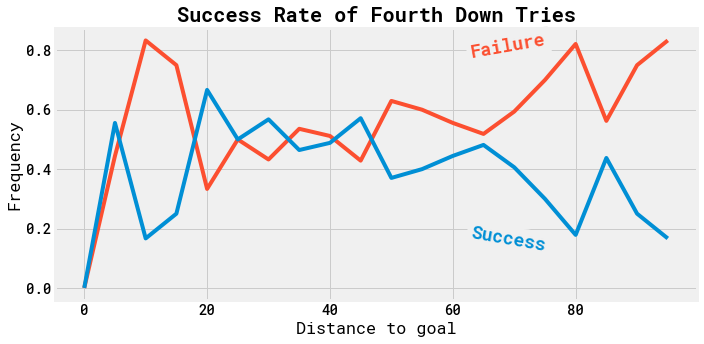

In [124]:
plt.figure(figsize=(10,5),facecolor='w')
plt.style.use('fivethirtyeight')
plt.title('Success Rate of Fourth Down Tries',weight='bold')
plt.xlabel('Distance to goal')
plt.ylabel('Frequency')
plt.plot(triesRange2,triesmissList2,label='Fail',color='C1')
plt.plot(triesRange2,triesgoodList2,label='Success',color='C0')
# for i in [10,20,30,40,50,60,70,80,90]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5)
# for i in [15,25,35,45,55,65]:
#     plt.axvline(i,c='w',lw=1,alpha=0.5,ls='--')
# plt.xlim(0.5,30.5)
# plt.ylim(0,1)
# plt.legend()
plt.text(x = 62.75, y = 0.775, s = 'Failure', color = 'C1', weight = 'bold', size = 18, rotation = 10, backgroundcolor = '#f0f0f0')
plt.text(x = 62.75, y = 0.125, s = 'Success', color = 'C0', weight = 'bold', rotation = -10, size = 18, backgroundcolor = '#f0f0f0')
plt.tight_layout()
plt.savefig('images/tryResults_field_line.png')
plt.show()

In [125]:
pd.set_option('display.max_colwidth', -1)
triesDF[(triesDF['distance']>=15) & (triesDF['tryResult'] == 'Good')].sort_values('distance',ascending=False)

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,index,Unnamed: 0.1,teamID,Q,time,totTime,down,distance,side,yard,play,gameID,S,homeTeam,awayTeam,recTeam,dist2goal,awayScore,homeScore,playType,scoreDiff,tryResult
51104,51104,396,192,8,4,1:04,64,4.0,24.0,NO,23.0,"Pass by Maximus III, B., complete to Fyodorovich, V. for 24 yds. Tackle by Hondo, A..",3206,14,BAL,NO,NO,77.0,20,31,Try,11,Good
201374,201374,8400,212,6,4,0:25,25,4.0,23.0,SJS,48.0,"Pass by Jack (R), ""., complete to McDavid, L. for 26 yds. Tackle by Jensen, C..",5635,23,YKW,SJS,SJS,52.0,34,27,Try,-7,Good
25781,25781,211,211,3,4,7:14,434,4.0,22.0,COL,18.0,"Pass by McCormick, M., complete to Wachter, J. for 33 yds. Tackle by Grithead, D..",2878,12,OCO,COL,COL,82.0,24,48,Try,24,Good
200326,200326,7352,176,1,4,1:29,89,4.0,22.0,BAL,6.0,"Fujiwara, C. SACKED by Galf Wilf - LB for -6 yds. The play results in a SAFETY!",5630,23,AZ,BAL,BAL,94.0,14,19,Try,5,Good
167495,167495,7281,211,7,4,3:12,192,4.0,20.0,PHI,23.0,"Pass by Phoenix, B., complete to Vuxta, R. for 22 yds. Tackle by Rector, D..",5187,21,NO,PHI,PHI,77.0,9,33,Try,24,Good
276027,276027,11446,207,3,4,5:24,324,4.0,19.0,COL,33.0,"Pass by Pierno, N., complete to Tweed, B. for 22 yds. Tackle by Floggity, J..",776,4,YKW,COL,COL,67.0,0,31,Try,31,Good
90208,90208,14621,195,6,4,7:42,462,4.0,19.0,SJS,24.0,"Pass by Christ, J., complete to Flash, X. for 28 yds. Tackle by Lee, L..",3937,16,AZ,SJS,SJS,76.0,14,41,Try,27,Good
186512,186512,11122,209,3,4,6:39,399,4.0,19.0,COL,30.0,"Pass by McDummy, W., complete to Bishop, J. for 36 yds. Tackle by Quaid, D..",5412,22,YKW,COL,COL,70.0,3,27,Try,24,Good
188367,188367,12977,195,5,4,1:18,78,4.0,18.0,OCO,10.0,"Pass by Armstrong, F., complete to Phillips (R), J. for 23 yds. Tackle by Lavelle Jr., D..",5421,22,OCO,AUS,OCO,90.0,28,20,Try,8,Good
89384,89384,13797,209,10,4,2:08,128,4.0,18.0,PHI,48.0,"Pass by Cole (R), E., complete to Tidwell (R), R. for 43 yds. Tackle by Verden, J..",3933,16,PHI,AUS,AUS,48.0,13,31,Try,18,Good
